# Descripción del proyecto

La finalidad del proyecto es preparar un prototipo de un modelo de machine learning para Zyfra. La empresa desarrolla soluciones de eficiencia para la industria pesada.

El modelo debe predecir la cantidad de oro extraído del mineral de oro. El modelo ayudará a optimizar la producción y a eliminar los parámetros no rentables. Se dispone de los datos de extracción y purificación. 


## Información general

### Inicialización

Importamos las librerías necesarias.

In [45]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

Leemos tres datasets: gold_train (conjunto de entrenamiento), gold_test (conjunto de prueba) y gold_full (contiene los conjuntos de entrenamiento y prueba con todas las características). 

Los datos contiene información acerca de los procesos tecnológicos en la extracción del oro, parámetros y el elemento que se mide. 

Los procesos tecnológicos son:
- Rougher feed — materia prima
- Rougher additions (o adiciones de reactivos) - reactivos de flotación: xantato, sulfato, depresante.
- Depresante — silicato de sodio
- Rougher process — flotación
- Rougher tails — residuos del producto
- Float banks — instalación de flotación
- Cleaner process — purificación
- Rougher Au — concentrado de oro rougher
- Final Au — concentrado de oro final

Los parámetros de las etapas son:
- air amount — volumen de aire
- fluid levels
- feed size — tamaño de las partículas de la alimentación
- feed rate

Los elementos que se encuentran en el proceso son Oro, Plata y Plomo, además de los datos de la solución entera.

Leemos los datos del conjunto de entrenamiento.

In [46]:
try:
    gold_train=pd.read_csv('gold_recovery_train.csv')
except:
    gold_train=pd.read_csv('/datasets/gold_recovery_train.csv')
gold_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


Leemos los datos del conjunto de prueba.

In [47]:
try:
    gold_test=pd.read_csv('gold_recovery_test.csv')
except:
    gold_test=pd.read_csv('/datasets/gold_recovery_test.csv')
gold_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

Leemos los datos del conjunto total.

In [48]:
try:
    gold_full=pd.read_csv('gold_recovery_full.csv')
except:
    gold_full=pd.read_csv('/datasets/gold_recovery_full.csv')
gold_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


### Preprocesamiento

Comprobamos que el cálculo de la recuperación de la característica rougher.output.recovery mediante el conjunto de entrenamiento sea correcto.

Eliminamos los valores nulos en 'gold_train'.

In [49]:
gold_train=gold_train.dropna()

Realizamos el cálculo de recuperación de acuerdo con la fórmula:

$$Recuperación = \frac{C \times (F-T)}{F \times (C-T)} \times 100  $$

In [50]:
C=gold_train['rougher.output.concentrate_au']
F=gold_train['rougher.input.feed_au']
T=gold_train['rougher.output.tail_au']

recuperacion=100*C*(F-T)/(F*(C-T))
recuperacion

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Length: 11017, dtype: float64

Evaluamos mediante el EAM los cálculos realizados del valor de recuperacion y los valores de la característica.

In [51]:
print('EAM:',mean_absolute_error(gold_train['rougher.output.recovery'],recuperacion))

EAM: 1.1235694834961156e-14


De acuerdo con la notación científica, este valor podría ser considerado como 0.

Analizamos las características no disponibles en el conjunto de prueba.

In [52]:
gold_train.shape, gold_test.shape

((11017, 87), (5856, 53))

In [53]:
set(gold_train.columns)-set(gold_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Hay 33 columnas faltantes en el conjunto de prueba; sin embargo, no todas son esenciales para el análisis, por lo que solo añadiremos las variables objetivo 'rougher.output.recovery' y 'final.output.recovery' extrayéndolas del conjunto total.

Seleccionamos las columnas del dataset gold_full guiándonos de la fecha y hora de la muestra.

In [54]:
date_test=gold_test['date']
col_test=gold_full.query('date in @date_test')[['rougher.output.recovery','final.output.recovery']]
col_test.index=gold_test['date'].index
col_test

,rougher.output.recovery,final.output.recovery
0,89.993421,70.273583
1,88.089657,68.910432
2,88.412756,68.143213
3,87.360133,67.776393
4,83.236367,61.467078
...,...,...
5851,95.172585,68.919891
5852,94.575036,68.440582
5853,93.018138,67.092759
5854,92.599042,68.061186


Añadimos las columnas al conjunto de prueba.

In [55]:
gold_test['rougher.output.recovery']=col_test['rougher.output.recovery']
gold_test['final.output.recovery']=col_test['final.output.recovery']
gold_test=gold_test.drop(['date'],axis=1)
gold_test=gold_test.dropna()
gold_test

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,87.360133,67.776393
4,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,83.236367,61.467078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,-499.599127,...,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909,95.172585,68.919891
5852,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,-503.587739,...,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761,94.575036,68.440582
5853,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,-520.667442,...,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882,93.018138,67.092759
5854,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,-487.479567,...,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284,92.599042,68.061186


## Análisis

### Concentración de metales

Observamos cómo cambia la concentración de metales (Au, Ag, Pb) en función de la etapa de purificación:
- Antes de la flotación
- Al salir de la flotación
- Después de la primera limpieza
- Al finalizar el proceso

In [56]:
au=gold_train[['rougher.input.feed_au','rougher.output.concentrate_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au']]
ag=gold_train[['rougher.input.feed_ag','rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']]
pb=gold_train[['rougher.input.feed_pb','rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']]

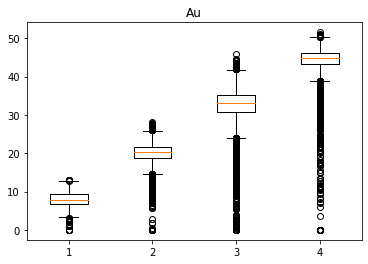

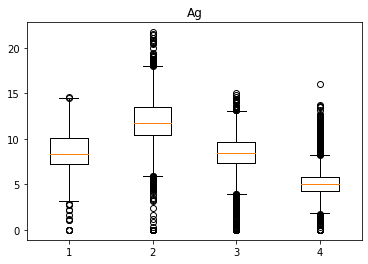

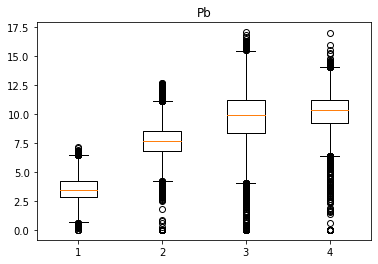

In [57]:
fig1, ax1 = plt.subplots()
ax1.set_title('Au')
ax1.boxplot(au)

fig2, ax2 = plt.subplots()
ax2.set_title('Ag')
ax2.boxplot(ag)
fig3, ax3 = plt.subplots()
ax3.set_title('Pb')
ax3.boxplot(pb)

plt.show()

- Se observó que la concentración de Oro en la solución creció de forma lineal desde 9 a 45 aproximadamente. 
- La concentración de plata subió después de la flotación, pero descendió hasta 5 al finalizar el proceso. 
- La concentración de plomo subió desde 3 hasta cerca de 10 al finalizar la primera limpieza y aumentó un poco adicional al finalizar el proceso.

### Tamaño de partículas

Comparamos las distribuciones del tamaño de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba.

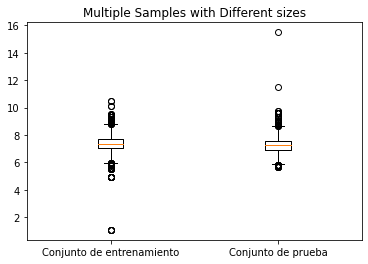

In [58]:
data=[gold_train['primary_cleaner.input.feed_size'],gold_test['primary_cleaner.input.feed_size']]
fig4, ax4 = plt.subplots()
ax4.set_title('Multiple Samples with Different sizes')
ax4.boxplot(data)
plt.xticks([1, 2], ['Conjunto de entrenamiento','Conjunto de prueba' ])
plt.show()

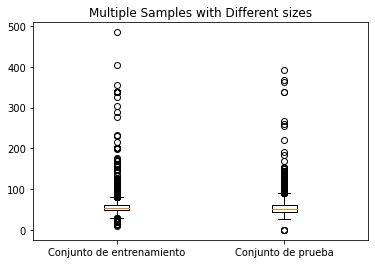

In [59]:
data=[gold_train['rougher.input.feed_size'],gold_test['rougher.input.feed_size']]
fig5, ax5 = plt.subplots()
ax5.set_title('Multiple Samples with Different sizes')
ax5.boxplot(data)
plt.xticks([1, 2], ['Conjunto de entrenamiento','Conjunto de prueba' ])
plt.show()

In [60]:
gold_train['rougher.input.feed_size'].describe(),gold_test['rougher.input.feed_size'].describe()


(count    11017.000000
 mean        57.215128
 std         18.913146
 min          9.659576
 25%         48.397242
 50%         53.843359
 75%         61.461770
 max        484.967466
 Name: rougher.input.feed_size, dtype: float64,
 count    5229.000000
 mean       55.863978
 std        18.914656
 min         0.046369
 25%        43.911874
 50%        50.772729
 75%        62.265394
 max       392.494040
 Name: rougher.input.feed_size, dtype: float64)

Evidenciamos que no hay una diferencia significativa entre los promedios de ambas mediciones.

### Anomalías

Examinamos las concentraciones totales de todas las sustancias en las diferentes etapas: materia prima, concentrado rougher y concentrado final.

In [61]:
conc_tot=gold_train[['rougher.input.feed_sol','rougher.output.concentrate_sol','final.output.concentrate_sol']]
conc_tot.describe()

,rougher.input.feed_sol,rougher.output.concentrate_sol,final.output.concentrate_sol
count,11017.000000,11017.000000,11017.000000
mean,36.555876,28.667674,9.600570
std,4.582155,5.945802,2.842305
min,0.010000,0.000000,0.000000
25%,34.324135,26.977539,7.951464
50%,37.052565,29.541871,9.268787
75%,39.453845,32.035128,10.904933
max,48.363177,38.351193,18.124851


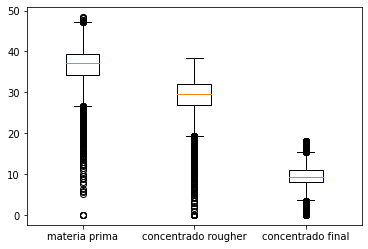

In [62]:
plt.boxplot(conc_tot)
plt.xticks([1, 2,3], ['materia prima','concentrado rougher','concentrado final' ])
plt.show()

Eliminamos los valores muy inferiores al cuartil 0.25.

In [63]:
gold_train=gold_train.loc[gold_train['rougher.input.feed_sol']>5]
gold_train=gold_train.loc[gold_train['rougher.output.concentrate_sol']>1]
gold_train=gold_train.loc[gold_train['final.output.concentrate_sol']>0]

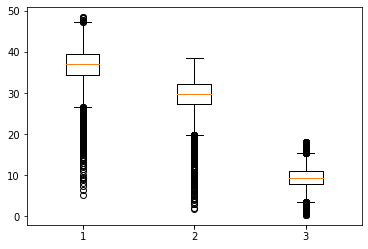

In [64]:
conc_tot=gold_train[['rougher.input.feed_sol','rougher.output.concentrate_sol','final.output.concentrate_sol']]
plt.xticks([1, 2,3], ['materia prima','concentrado rougher','concentrado final' ])
plt.boxplot(conc_tot)
plt.show()

Se eliminaron los valores de concentración de la solución igual y cercano a 0. Además, se observó que la concentración va descendiendo conforme avanza el proceso.

## Entrenamiento de modelo

### Función sMAPE

Definimos una función para calcular el valor sMAPE. El valor final sMAPE se realizará en cada modelo de Machine Learning.

In [65]:
def calculate_smape(target,prediction):
    suma=2*(np.abs(target-prediction)).sum()/(np.abs(target).sum()+np.abs(prediction).sum())
    smape=100*(suma)/len(target)
    return smape

### Preparación para entrenamiento

En el conjunto de entrenamiento seleccionamos solo las columnas que en el conjunto de prueba.

In [66]:
gold_train=gold_train[(gold_test.columns)]

Realizamos el método de escalamiento en los conjuntos de entrenamiento y prueba en las columnas numéricas.

In [67]:
numeric=gold_test.columns[0:-2]
numeric

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatba

Realizamos el escalamiento en gold_train.

In [68]:
scaler=StandardScaler()

scaler.fit(gold_train[numeric])
gold_train[numeric]=scaler.transform(gold_train[numeric])
gold_train.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,-0.381639,0.237554,-0.259722,0.261259,-0.431625,-0.302249,-0.429600,-0.805438,-0.419732,-0.278836,...,-0.548423,-0.793166,-1.120384,-0.404831,-0.799278,-0.445365,-1.084841,-2.445214,87.107763,70.541216
1,-0.422250,0.287150,-0.259722,0.299300,-0.231343,-0.360001,-0.245581,-0.323313,-0.227030,-0.297329,...,-0.576062,-0.736938,-1.100962,-0.450350,-0.815424,-0.448041,-1.112324,-2.292897,86.843261,69.266198
2,-0.472484,0.588361,-0.259722,0.268117,-0.038661,-0.333711,-0.062165,-0.344941,-0.035146,-0.341672,...,-0.583045,-0.733646,-1.095548,-0.449350,-0.810470,-0.446486,-1.106879,-2.334158,86.842308,68.116445
3,-0.515506,0.590092,-0.259722,0.283091,-0.050708,-0.361357,-0.060119,-0.317809,-0.047684,-0.337620,...,-0.566993,-0.734647,-1.112737,-0.426649,-0.816688,-0.440190,-1.111031,-2.298153,87.226430,68.347543
4,-0.634387,0.764752,-0.259722,0.319016,-0.040304,-0.304084,-0.054275,-0.336647,-0.053012,-0.342188,...,-0.575592,-0.732325,-1.120371,-0.487473,-0.830823,-0.442599,-1.112630,-2.335902,86.688794,66.927016


Realizamos el escalamiento en gold_test.

In [69]:
scaler=StandardScaler()

scaler.fit(gold_test[numeric])
gold_test[numeric]=scaler.transform(gold_test[numeric])
gold_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,0.836516,2.077780,1.334460,-0.602722,-1.268261,-0.135670,-1.246938,0.000331,-1.101158,-0.114207,...,-1.685180,-0.449936,-1.619895,4.202391,-1.761313,-0.133831,2.069979,0.049904,89.993421,70.273583
1,0.946387,2.075911,1.334460,-0.625430,-1.270090,-0.126390,-1.256189,0.005074,-1.134888,-0.041976,...,-1.651613,-0.430190,-1.616015,-1.509690,-1.759096,-0.137529,1.696840,0.047058,88.089657,68.910432
2,0.943216,1.380135,0.850275,-0.616732,-1.272647,-0.171146,-1.249353,0.005532,-1.118461,-0.185597,...,-1.661621,-0.444427,-1.578638,0.019568,-1.749906,-0.127647,1.691290,0.026285,88.412756,68.143213
3,0.945042,1.089542,0.608182,-0.823538,-1.262532,-0.060499,-1.261412,0.024078,-1.100934,0.001647,...,-1.668065,-0.428283,-1.636291,0.015485,-1.740716,-0.131646,1.681121,0.075755,87.360133,67.776393
4,0.556509,0.651310,0.426613,-0.913950,-1.247690,-0.167832,-1.255565,0.014243,-1.083498,-0.119448,...,-1.674016,-0.439297,-1.566431,-0.513337,-1.731526,-0.143379,1.693164,0.020239,83.236367,61.467078


Dividimos gold_train en conjuntos de entrenamiento y de validación.

In [70]:
features_train=gold_train.drop(['rougher.output.recovery','final.output.recovery'],axis=1)
target_train=gold_train[['rougher.output.recovery','final.output.recovery']]

In [71]:
features_train, features_valid, target_train, target_valid = train_test_split(features_train,target_train,test_size=0.25,random_state=54321)

In [72]:
features_test=gold_test.drop(['rougher.output.recovery','final.output.recovery'],axis=1)
target_test=gold_test[['rougher.output.recovery','final.output.recovery']]

In [73]:
target_train.shape, target_valid.shape, target_test.shape

((8083, 2), (2695, 2), (5229, 2))

 ###  Regresión lineal

Realizamos el entrenamiento y comprobamos en conjunto de validación.

In [74]:
model_reg_lin = LinearRegression() 
model_reg_lin.fit(features_train,target_train['rougher.output.recovery']) 
predictions_valid_rougher = model_reg_lin.predict(features_valid)

model_reg_lin = LinearRegression() 
model_reg_lin.fit(features_train,target_train['final.output.recovery']) 
predictions_valid_final = model_reg_lin.predict(features_valid)

In [75]:
smape_reg=calculate_smape(target_valid['rougher.output.recovery'],predictions_valid_rougher)+0.75*calculate_smape(target_valid['final.output.recovery'],predictions_valid_final)
print('SMAPE final en regresión lineal en conjunto de validación:',smape_reg)

SMAPE final en regresión lineal en conjunto de validación: 0.00330952159792731


En conjunto de prueba.

In [76]:
model_reg_lin = LinearRegression() 
model_reg_lin.fit(features_train,target_train['rougher.output.recovery']) 
predictions_test_rougher = model_reg_lin.predict(features_test)

model_reg_lin = LinearRegression() 
model_reg_lin.fit(features_train,target_train['final.output.recovery']) 
predictions_test_final = model_reg_lin.predict(features_test)

In [77]:
smape_reg=calculate_smape(target_test['rougher.output.recovery'],predictions_test_rougher)+0.75*calculate_smape(target_test['final.output.recovery'],predictions_test_final)
print('SMAPE final en regresión lineal en conjunto de prueba:',smape_reg)

SMAPE final en regresión lineal en conjunto de prueba: 0.0025912998424980583


In [78]:
print('EAM de rougher.output.recovery:',mean_absolute_error(target_test['rougher.output.recovery'],predictions_test_rougher))
print('EAM de final.output.recovery:',mean_absolute_error(target_test['final.output.recovery'],predictions_test_final))

EAM de rougher.output.recovery: 5.800793635728255
EAM de final.output.recovery: 6.06205211122318


Elaboramos un gráfico de dispersion de la predicción vs el valor real. Mientras más cercano horizontalmente se encuentre el valor a la diagonal, la predicción es más certera.

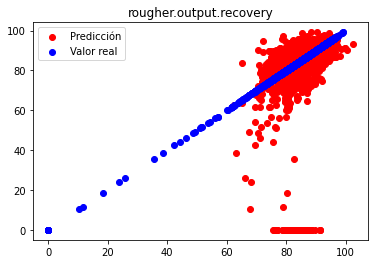

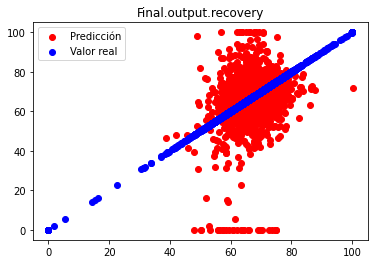

In [79]:
#ROUGHER OUTPUT RECOVERY
x1 = predictions_test_rougher
y1 = target_test['rougher.output.recovery']
plt.scatter(x1, y1, c = "red", label = "Predicción")

x2 = target_test['rougher.output.recovery']
y2 = target_test['rougher.output.recovery']
plt.scatter(x2, y2, c = "blue", label = "Valor real")

plt.title('rougher.output.recovery')
plt.legend()
plt.show()


#FINAL OUTPUT RECOVERY
x1 = predictions_test_final
y1 = target_test['final.output.recovery']

plt.scatter(x1, y1, c = "red", label = "Predicción")

# Datos 2
x2 = target_test['final.output.recovery']
y2 = target_test['final.output.recovery']

plt.scatter(x2, y2, c = "blue", label = "Valor real")

# Leyenda
plt.title('Final.output.recovery')
plt.legend()
plt.show()

El valor de sMAPE final es de 0.0025. El valor de EAM de la predicción del concentrado rougher es 5.8, mientras que del concentrado final es 6.062. El gráfico nos indica una media superior en el valor del concentrado rougher.

### Árbol de decisiones

Realizamos el entrenamiento y comprobamos en conjunto de validación.

In [80]:
best_score=10000
best_depth=0

for depth in range(1,21):
    model_tree = DecisionTreeRegressor(random_state=12345,max_depth=depth) 
    model_tree.fit(features_train,target_train['rougher.output.recovery'])
    predictions_valid_rougher = model_tree.predict(features_valid)
                                       
    model_tree = DecisionTreeRegressor(random_state=12345,max_depth=depth)
    model_tree.fit(features_train,target_train['final.output.recovery']) 
    predictions_valid_final = model_tree.predict(features_valid)
 
    smape_tree=calculate_smape(target_valid['rougher.output.recovery'],predictions_valid_rougher)+0.75*calculate_smape(target_valid['final.output.recovery'],predictions_valid_final)

    if smape_tree < best_score:
        best_score = smape_tree
        best_depth = depth   
    
print("SMAPE del mejor modelo en el conjunto de validación (best depth = {}): {}".format(best_depth, best_score))

SMAPE del mejor modelo en el conjunto de validación (best depth = 11): 0.002721256143829947


En conjunto de prueba.

In [81]:
model_tree = DecisionTreeRegressor(random_state=12345,max_depth=13) 
model_tree.fit(features_train,target_train['rougher.output.recovery'])
predictions_test_rougher = model_tree.predict(features_test)

model_tree = DecisionTreeRegressor(random_state=12345,max_depth=13)
model_tree.fit(features_train,target_train['final.output.recovery']) 
predictions_test_final = model_tree.predict(features_test)

In [82]:
smape_tree=calculate_smape(target_test['rougher.output.recovery'],predictions_test_rougher)+0.75*calculate_smape(target_test['final.output.recovery'],predictions_test_final)
print('SMAPE final en árbol de decisión:',smape_tree)

SMAPE final en árbol de decisión: 0.0037405769864832434


In [83]:
print('EAM de rougher.output.recovery:',mean_absolute_error(target_test['rougher.output.recovery'],predictions_test_rougher))
print('EAM de final.output.recovery:',mean_absolute_error(target_test['final.output.recovery'],predictions_test_final))

EAM de rougher.output.recovery: 7.579410785132516
EAM de final.output.recovery: 9.675047845492461


Elaboramos un gráfico de dispersion de la predicción vs el valor real. Mientras más cercano horizontalmente se encuentre el valor a la diagonal, la predicción es más certera.

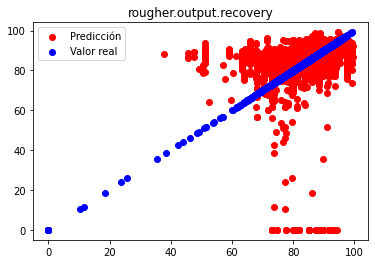

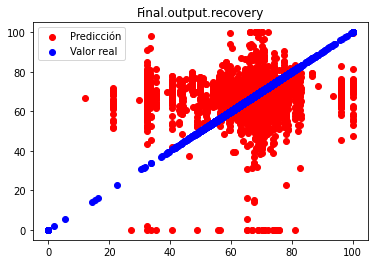

In [84]:
#ROUGHER OUTPUT RECOVERY
x1 = predictions_test_rougher
y1 = target_test['rougher.output.recovery']
plt.scatter(x1, y1, c = "red", label = "Predicción")

x2 = target_test['rougher.output.recovery']
y2 = target_test['rougher.output.recovery']
plt.scatter(x2, y2, c = "blue", label = "Valor real")

plt.title('rougher.output.recovery')
plt.legend()
plt.show()


#FINAL OUTPUT RECOVERY
x1 = predictions_test_final
y1 = target_test['final.output.recovery']

plt.scatter(x1, y1, c = "red", label = "Predicción")

# Datos 2
x2 = target_test['final.output.recovery']
y2 = target_test['final.output.recovery']

plt.scatter(x2, y2, c = "blue", label = "Valor real")

# Leyenda
plt.title('Final.output.recovery')
plt.legend()
plt.show()

El valor de sMAPE final es de 0.0037. El valor de EAM de la predicción del concentrado rougher es 7.57, mientras que del concentrado final es 9.67. El gráfico nos indica una media superior en el valor del concentrado rougher; sin embargo, nos indica también una variación muy amplia horizontalmente.

###  Bosque aleatorio

Realizamos el entrenamiento y comprobamos en conjunto de validación.

In [85]:
best_model = None
best_score = 10000
best_est = 0
best_depth = 0
for est in range(10, 31, 5):
    for depth in range (1, 11):
        model_forest = RandomForestRegressor(random_state=12345,n_estimators=est,max_depth=depth)
        model_forest.fit(features_train,target_train['rougher.output.recovery']) 
        predictions_valid_rougher = model_forest.predict(features_valid)
        
        model_forest = RandomForestRegressor(random_state=12345,n_estimators=est,max_depth=depth)
        model_forest.fit(features_train,target_train['final.output.recovery']) 
        predictions_valid_final = model_forest.predict(features_valid)
        
        smape_tree=calculate_smape(target_valid['rougher.output.recovery'],predictions_valid_rougher)+0.75*calculate_smape(target_valid['final.output.recovery'],predictions_valid_final)

        if smape_tree < best_score:
            best_model = model_forest
            best_score = smape_tree
            best_est = est
            best_depth = depth

print("SMAPE del mejor modelo en el conjunto de validación:", best_score, "n_estimators:", best_est, "best_depth:", depth)

SMAPE del mejor modelo en el conjunto de validación: 0.0024006873860121336 n_estimators: 30 best_depth: 10


Mejor n_estimators=30, bes_depth =10

In [86]:
model_forest = RandomForestRegressor(random_state=12345,n_estimators=30,max_depth=10)
model_forest.fit(features_train,target_train['rougher.output.recovery']) 
predictions_test_rougher = model_forest.predict(features_test)

model_forest = RandomForestRegressor(random_state=12345,n_estimators=est,max_depth=depth)
model_forest.fit(features_train,target_train['final.output.recovery']) 
predictions_test_final = model_forest.predict(features_test)

smape_tree=calculate_smape(target_test['rougher.output.recovery'],predictions_test_rougher)+0.75*calculate_smape(target_test['final.output.recovery'],predictions_test_final)
print("SMAPE final en bosque aleatorio:", smape_tree)

SMAPE final en bosque aleatorio: 0.002679725868036046


In [87]:
print('EAM de rougher.output.recovery:',mean_absolute_error(target_test['rougher.output.recovery'],predictions_test_rougher))
print('EAM de final.output.recovery:',mean_absolute_error(target_test['final.output.recovery'],predictions_test_final))

EAM de rougher.output.recovery: 6.194582987859272
EAM de final.output.recovery: 6.065207797027044


Elaboramos un gráfico de dispersion de la predicción vs el valor real. Mientras más cercano horizontalmente se encuentre el valor a la diagonal, la predicción es más certera.

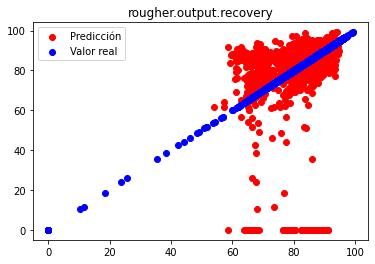

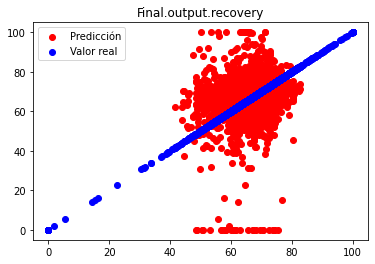

In [88]:
#ROUGHER OUTPUT RECOVERY
x1 = predictions_test_rougher
y1 = target_test['rougher.output.recovery']
plt.scatter(x1, y1, c = "red", label = "Predicción")

x2 = target_test['rougher.output.recovery']
y2 = target_test['rougher.output.recovery']
plt.scatter(x2, y2, c = "blue", label = "Valor real")

plt.title('rougher.output.recovery')
plt.legend()
plt.show()


#FINAL OUTPUT RECOVERY
x1 = predictions_test_final
y1 = target_test['final.output.recovery']

plt.scatter(x1, y1, c = "red", label = "Predicción")

# Datos 2
x2 = target_test['final.output.recovery']
y2 = target_test['final.output.recovery']

plt.scatter(x2, y2, c = "blue", label = "Valor real")

# Leyenda
plt.title('Final.output.recovery')
plt.legend()
plt.show()

El valor de sMAPE final es de 0.0026. El valor de EAM de la predicción del concentrado rougher es 6.19, mientras que del concentrado final es 6.065. El gráfico nos indica una media superior en el valor del concentrado rougher.

## Conclusiones

- Se observó que la concentración de Oro en la solución creció de forma lineal en las 3 etapas del proceso.
- De acuerdo con los valores sMAPE finales, el modelo más preciso es la regresión lineal, seguido del bosque aleatorio. Los tres modelos obtuvieron valores muy cercanos a 0.
- El modelo que generó un mejor valor del Error Absoluto Medio fue regresión lineal, seguido del bosque aleatorio.
- En general, se realizaron predicciones más precisas para el concentrado rougher en comparación con la concentración final.
- Según lo observado en el gráfico de dispersión, el árbol de decisiones mostró una dispersión muy amplia con respecto a la diagonal. El modelo de regresión lineal brindó una dispersión de puntos menor.
- El modelo más preciso es la regresión lineal, teniendo en cuenta los valores de sMAPE final, EAM y el gráfico de dispersión.